<a href="https://colab.research.google.com/github/bholu14401/Bhargav-Portfolio/blob/main/Bert_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
current_folder = os.getcwd()
dataset = tf.keras.utils.get_file(fname ="aclImdb.tar.gz", origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                  cache_dir= current_folder, extract = True)

84125825/84125825 [==============================] - 6s 0us/step


In [3]:
dataset_path = os.path.dirname(dataset)
os.listdir(dataset_path)

['aclImdb.tar.gz', 'aclImdb']

In [4]:
dataset_dir = os.path.join(dataset_path, 'aclImdb')
os.listdir(dataset_dir)

['train', 'README', 'imdbEr.txt', 'test', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['neg',
 'unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'urls_unsup.txt',
 'unsupBow.feat',
 'pos',
 'urls_neg.txt']

In [47]:
def load_dataset(directory):
	data = {"sentence": [], "sentiment": []}
	for file_name in os.listdir(directory):
		print(file_name)
		if file_name == 'pos':
			positive_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(positive_dir):
				text = os.path.join(positive_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(1)
		elif file_name == 'neg':
			negative_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(negative_dir):
				text = os.path.join(negative_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(0)
	return pd.DataFrame.from_dict(data)

In [8]:
train_df = load_dataset(train_dir)
print(train_df.head())

neg
unsup
labeledBow.feat
urls_pos.txt
urls_unsup.txt
unsupBow.feat
pos
urls_neg.txt
                                            sentence  sentiment
0  Whether you watch the regular version of this ...          0
1  Williamson's accent is tough to wade through. ...          0
2  Before I'd seen this, I had seen some pretty b...          0
3  Basically what we have here is little more tha...          0
4  If you really enjoyed the 2002 Resident Evil m...          0


In [9]:
test_dir = os.path.join(dataset_dir,'test')
test_df = load_dataset(test_dir)
print(test_df.head())

neg
labeledBow.feat
urls_pos.txt
pos
urls_neg.txt
                                            sentence  sentiment
0  I was suckered in by the big names. Rob Lowe, ...          0
1  Blake Edwards' legendary fiasco, begins to see...          0
2  You can see that if the flick ain't directed b...          0
3  I'm really surprised seeing all these positive...          0
4  Rarely does one find a movie so bad that it ac...          0


In [46]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts')

fig.show()


In [11]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text

In [12]:
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)


<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-11-2374454d2258>:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [40]:
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=600, height=600, stopwords=set(STOPWORDS), background_color='white').generate(all_text)
	plt.figure(figsize=(12, 6))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


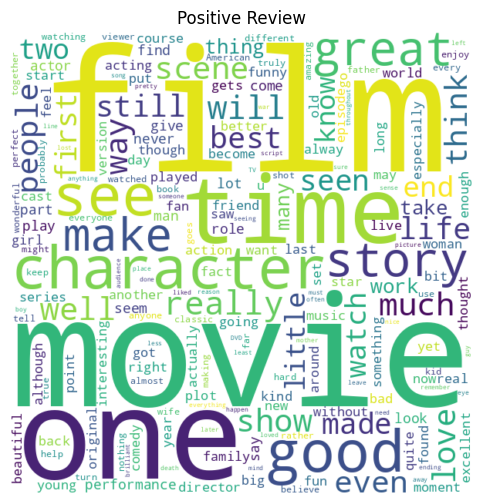

In [51]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

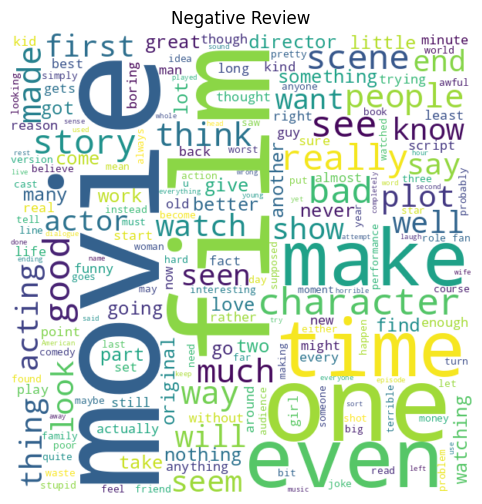

In [48]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [16]:
# Using 4000 data out of 25000 data to run code faster
train_df = pd.merge(train_df[:2000],train_df[-2000:], how = 'outer')
test_df = pd.merge(test_df[:2000],test_df[-2000:], how = 'outer')

In [17]:
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [18]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews, test_targets, test_size=0.5, stratify = test_targets)


In [19]:
#Tokenize and encode data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len= 128
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(), padding=True, truncation=True,
                                              max_length = max_len, return_tensors='tf')
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), padding=True, truncation=True,
                                            max_length = max_len, return_tensors='tf')
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), padding=True, truncation=True,
                                             max_length = max_len, return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3)

Epoch 1/3
125/125 [==============================] - 7242s 58s/step - loss: 0.4958 - accuracy: 0.7418 - val_loss: 0.3849 - val_accuracy: 0.8270
Epoch 2/3
125/125 [==============================] - 7160s 57s/step - loss: 0.2635 - accuracy: 0.8975 - val_loss: 0.3434 - val_accuracy: 0.8565
Epoch 3/3
125/125 [==============================] - 7106s 57s/step - loss: 0.1385 - accuracy: 0.9553 - val_loss: 0.4100 - val_accuracy: 0.8500


In [22]:
#Evaluate model on test data
test_loss, test_accuracy = model.evaluate(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
	y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')


63/63 [==============================] - 955s 15s/step - loss: 0.4118 - accuracy: 0.8545
Test loss: 0.41175177693367004, Test accuracy: 0.8544999957084656


In [23]:
path = 'path-to-save'
tokenizer.save_pretrained(path +'/Tokenizer')
model.save_pretrained(path +'/Model')

In [24]:
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

Some layers from the model checkpoint at path-to-save/Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at path-to-save/Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [25]:
pred = bert_model.predict(
	[X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

logits = pred.logits
pred_labels = tf.argmax(logits, axis=1)
pred_labels = pred_labels.numpy()
label = {
	1: 'positive',
	0: 'Negative'
}
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]
print('Predicted Label :', pred_labels[:10])
print('Actual Label :', Actual[:10])


63/63 [==============================] - 964s 15s/step
Predicted Label : ['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'Negative', 'positive', 'Negative']
Actual Label : ['positive', 'positive', 'positive', 'Negative', 'positive', 'positive', 'positive', 'Negative', 'positive', 'Negative']


In [26]:
print("Classification Report: \n", classification_report(Actual, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.89      0.81      0.85      1000
    positive       0.82      0.90      0.86      1000

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000



In [27]:
def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
	if not isinstance(Review, list):
		Review = [Review]
	Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
																			padding=True,
																			truncation=True,
																			max_length=128,
																			return_tensors='tf').values()
	prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])
	pred_labels = tf.argmax(prediction.logits, axis=1)
	pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
	return pred_labels


In [32]:
Review ='''This is a journey not a destination film. Used to be a lot of films like this. Today, not so much. That said, for its genre, it is top
of class. Burke has an everyman look and attitude which Jenkins uses to advantage. The characters, all superb, are people you want to meet once in
your life, but only once. Recommended.'''
Get_sentiment(Review)


1/1 [==============================] - 1s 587ms/step


['positive']

In [33]:
Review = '''This movie makes my skin crawl and i don't mean that as a compliment. The movie looks like a caricature of several British TV shows
badly joined together. Utterly without meaning or substance. Everyone praising the movie must either be directly involved with it or was handsomely
paid. Don't waste your time watching this trash, but on the other hand, if you're prepared to throw 2 hours of your life down the drain, then by all
means, please go ahead.'''
Get_sentiment(Review)

1/1 [==============================] - 1s 781ms/step


['Negative']